In [39]:
import seaborn as sns
import sys, os
import pandas as pd
import proplot as pplt
import nibabel as nib
import numpy as np
from scipy import ndimage
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
matplotlib.rcParams['font.family'] = 'Arial'
import scipy.io as sio
from scipy.integrate import solve_ivp
from matplotlib import cm
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

def compute_com(img):
    return tuple(int(s) for s in ndimage.measurements.center_of_mass(img))

Diffusion True positive:  0.15384615384615385
Diffusion Pearson correlation:  -0.017941231420498062
MRtrix3 True positive:  0.5769230769230769
MRtrix3 Pearson correlation:  0.683192431050198


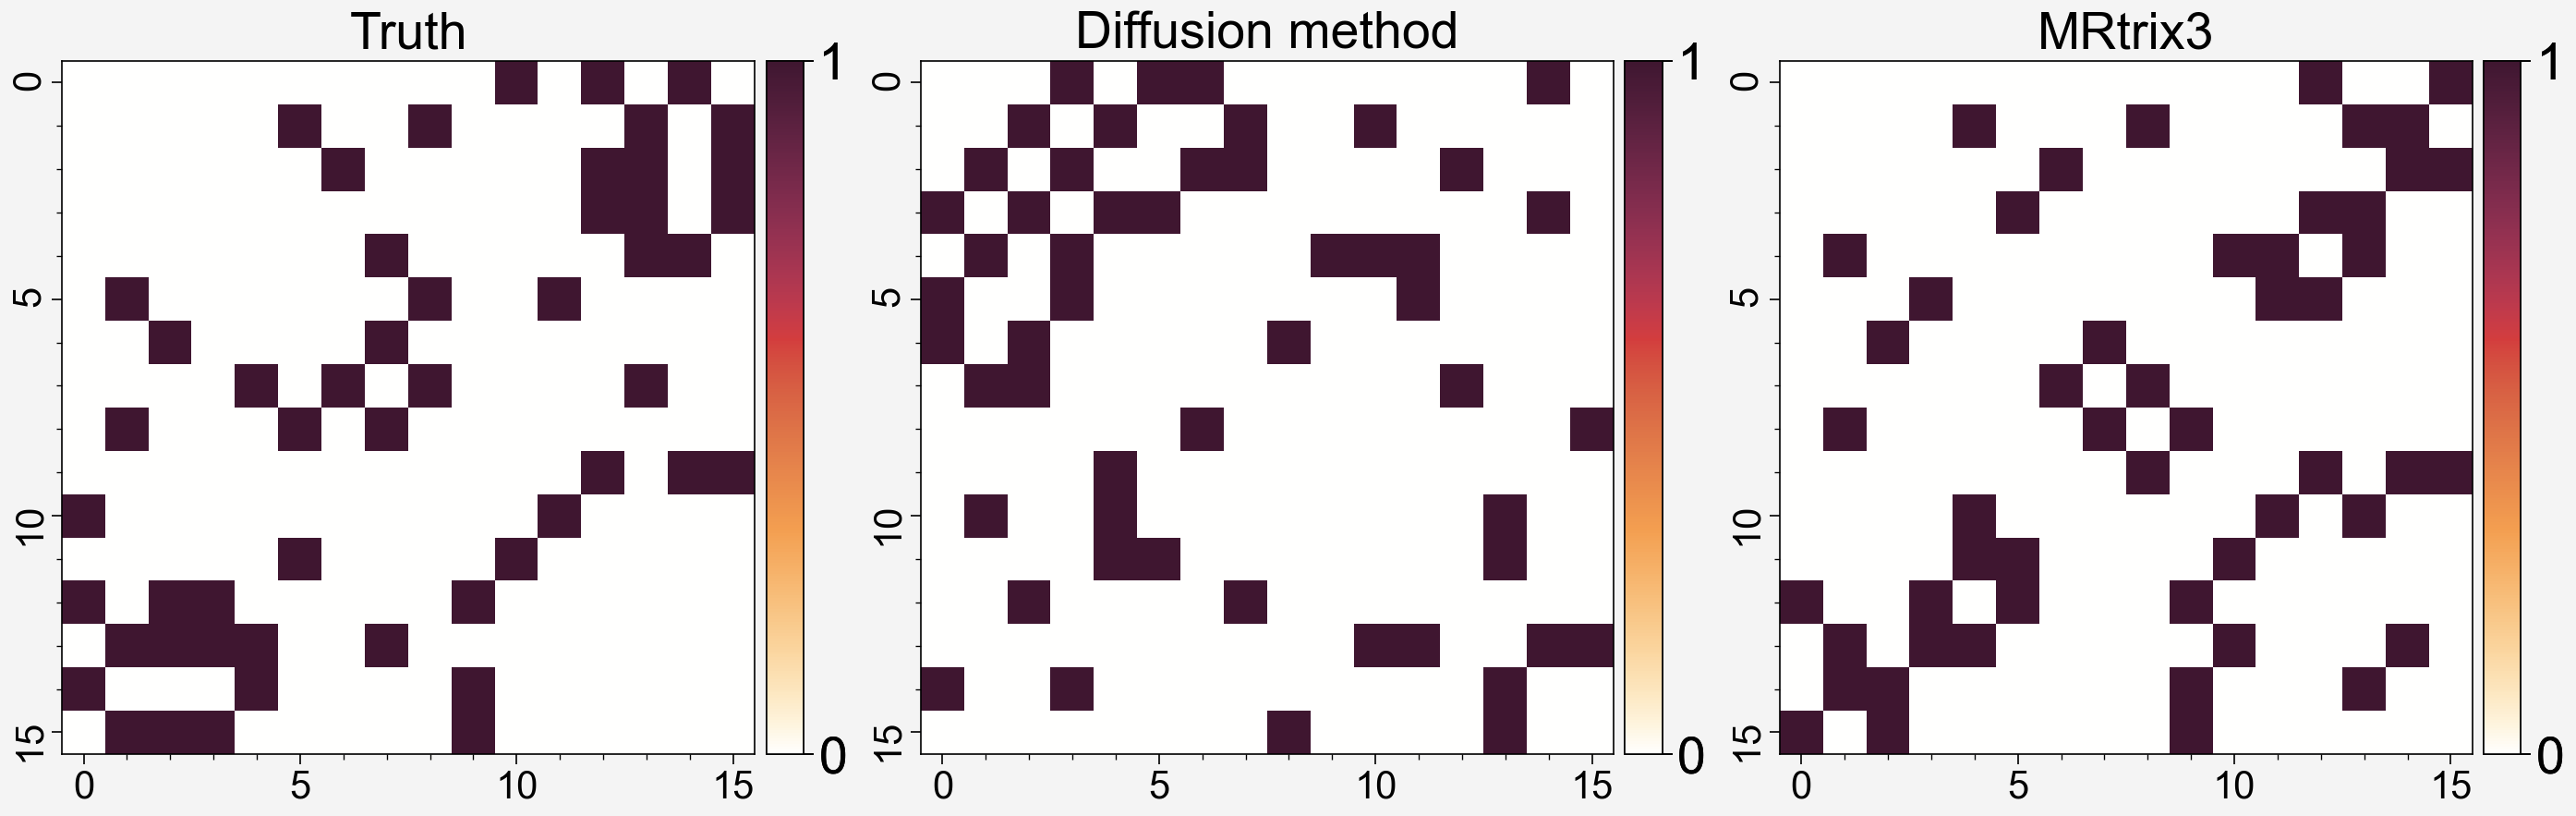

In [60]:
disco_id = 2
## load ground truth
truth = np.loadtxt('/Users/zheyu/Downloads/phantom_DWI/DiSCo{}/DiSCo{}_Connectivity_Matrix_Cross-Sectional_Area.txt'.format(disco_id, disco_id))
truth_binary = truth.copy()
truth_binary[truth_binary>0] = 1
sparsity = np.sum(truth_binary) / (truth_binary.shape[0] * truth_binary.shape[1])
truth_relative = truth.copy()
for i in range(16):
    truth_relative[i] /= np.sum(truth_relative[i])
truth_relative += truth_relative.T
truth_relative /= 2

## Diffusion results
conn_td = sio.loadmat('/Users/zheyu/Downloads/conn_mtx_tid_{}.mat'.format(disco_id))['data']
np.fill_diagonal(conn_td, 0)
conn_td_binary = conn_td.copy()
threshold = np.percentile(conn_td, 100 * (1 - sparsity))
conn_td_binary[conn_td_binary>threshold] = 1
conn_td_binary[conn_td_binary<threshold] = 0
TP = np.sum(truth_binary * conn_td_binary) / np.sum(truth_binary)
print('Diffusion True positive: ', TP)
print('Diffusion Pearson correlation: ', pearsonr(truth_relative.reshape([-1, ]), conn_td.reshape([-1, ]))[0])
# print('Diffusion r2_score: ', r2_score(truth_relative.reshape([-1, ]), conn_td_binary.reshape([-1, ])))
## MRtrix3 method
conn_mrtrix_file = pd.read_csv('/Users/zheyu/Downloads/connectome_1M_{}.csv'.format(disco_id))
conn_mrtrix = np.zeros_like(conn_td)
conn_mrtrix[0, :] = np.asarray(conn_mrtrix_file.keys()).astype('float')
conn_mrtrix[1:, :] = np.asarray(conn_mrtrix_file.values).astype('float')
conn_mrtrix += conn_mrtrix.T
np.fill_diagonal(conn_mrtrix, 0)
for i in range(16):
    conn_mrtrix[i] /= np.sum(conn_mrtrix[i])
conn_mrtrix += conn_mrtrix.T
conn_mrtrix /= 2

threshold = np.percentile(conn_mrtrix, 100 * (1 - sparsity))
conn_mrtrix_binary = conn_mrtrix.copy()
conn_mrtrix_binary[conn_mrtrix_binary>threshold] = 1
conn_mrtrix_binary[conn_mrtrix_binary<threshold] = 0

TP = np.sum(truth_binary * conn_mrtrix_binary) / np.sum(truth_binary)
print('MRtrix3 True positive: ', TP)
print('MRtrix3 Pearson correlation: ', pearsonr(truth_relative.reshape([-1, ]), conn_mrtrix.reshape([-1, ]))[0])
# print('MRtrix3 r2_score: ', r2_score(truth_relative.reshape([-1, ]), conn_mrtrix_binary.reshape([-1, ])))

pdf_file = '/Users/zheyu/Downloads/conn_fig.pdf'
max_val = 1
ticks = np.arange(0, 16, 5).astype('int')
with PdfPages(pdf_file) as pdf:
    fig = pplt.figure(share=False, refwidth='30em')
    axs = fig.subplots(nrows=1, ncols=3)
    m1 = axs[0].imshow(truth_binary)
    axs[0].grid(False)
    axs[0].set_xticks(list(ticks))
    axs[0].set_xticklabels(ticks, fontsize=15)
    axs[0].set_yticks(list(ticks))
    axs[0].set_yticklabels(ticks, fontsize=15, rotation=90)
    axs[0].set_title('Truth', fontsize=20)
    cbar = fig.colorbar(m1, ax=axs[0], ticks=[0, max_val], shrink=1)
    cbar.ax.tick_params(labelsize=20)
    m1 = axs[1].imshow(conn_td_binary)
    axs[1].grid(False)
    axs[1].set_xticks(list(ticks))
    axs[1].set_xticklabels(ticks, fontsize=15)
    axs[1].set_yticks(list(ticks))
    axs[1].set_yticklabels(ticks, fontsize=15, rotation=90)
    axs[1].set_title('Diffusion method', fontsize=20)
    cbar = fig.colorbar(m1, ax=axs[1], ticks=[0, max_val], shrink=1)
    cbar.ax.tick_params(labelsize=20)
    m1 = axs[2].imshow(conn_mrtrix_binary)
    axs[2].grid(False)
    axs[2].set_xticks(list(ticks))
    axs[2].set_xticklabels(ticks, fontsize=15)
    axs[2].set_yticks(list(ticks))
    axs[2].set_yticklabels(ticks, fontsize=15, rotation=90)
    axs[2].set_title('MRtrix3', fontsize=20)
    cbar = fig.colorbar(m1, ax=axs[2], ticks=[0, max_val], shrink=1)
    cbar.ax.tick_params(labelsize=20)
    pdf.savefig(dpi = 256)
    pplt.show()
    pplt.close()

/var/folders/_1/84dk44951w16_wfcqz9h1dpw0000gn/T/ipykernel_1373/2169475055.py:51: ProplotWarning: Got conflicting or duplicate keyword args: {'length': 0.7, 'shrink': 1}. Using the first one.
  cbar = fig.colorbar(m, ticks=[0, max_val], shrink=1, loc='b', length=0.7, width=0.5)


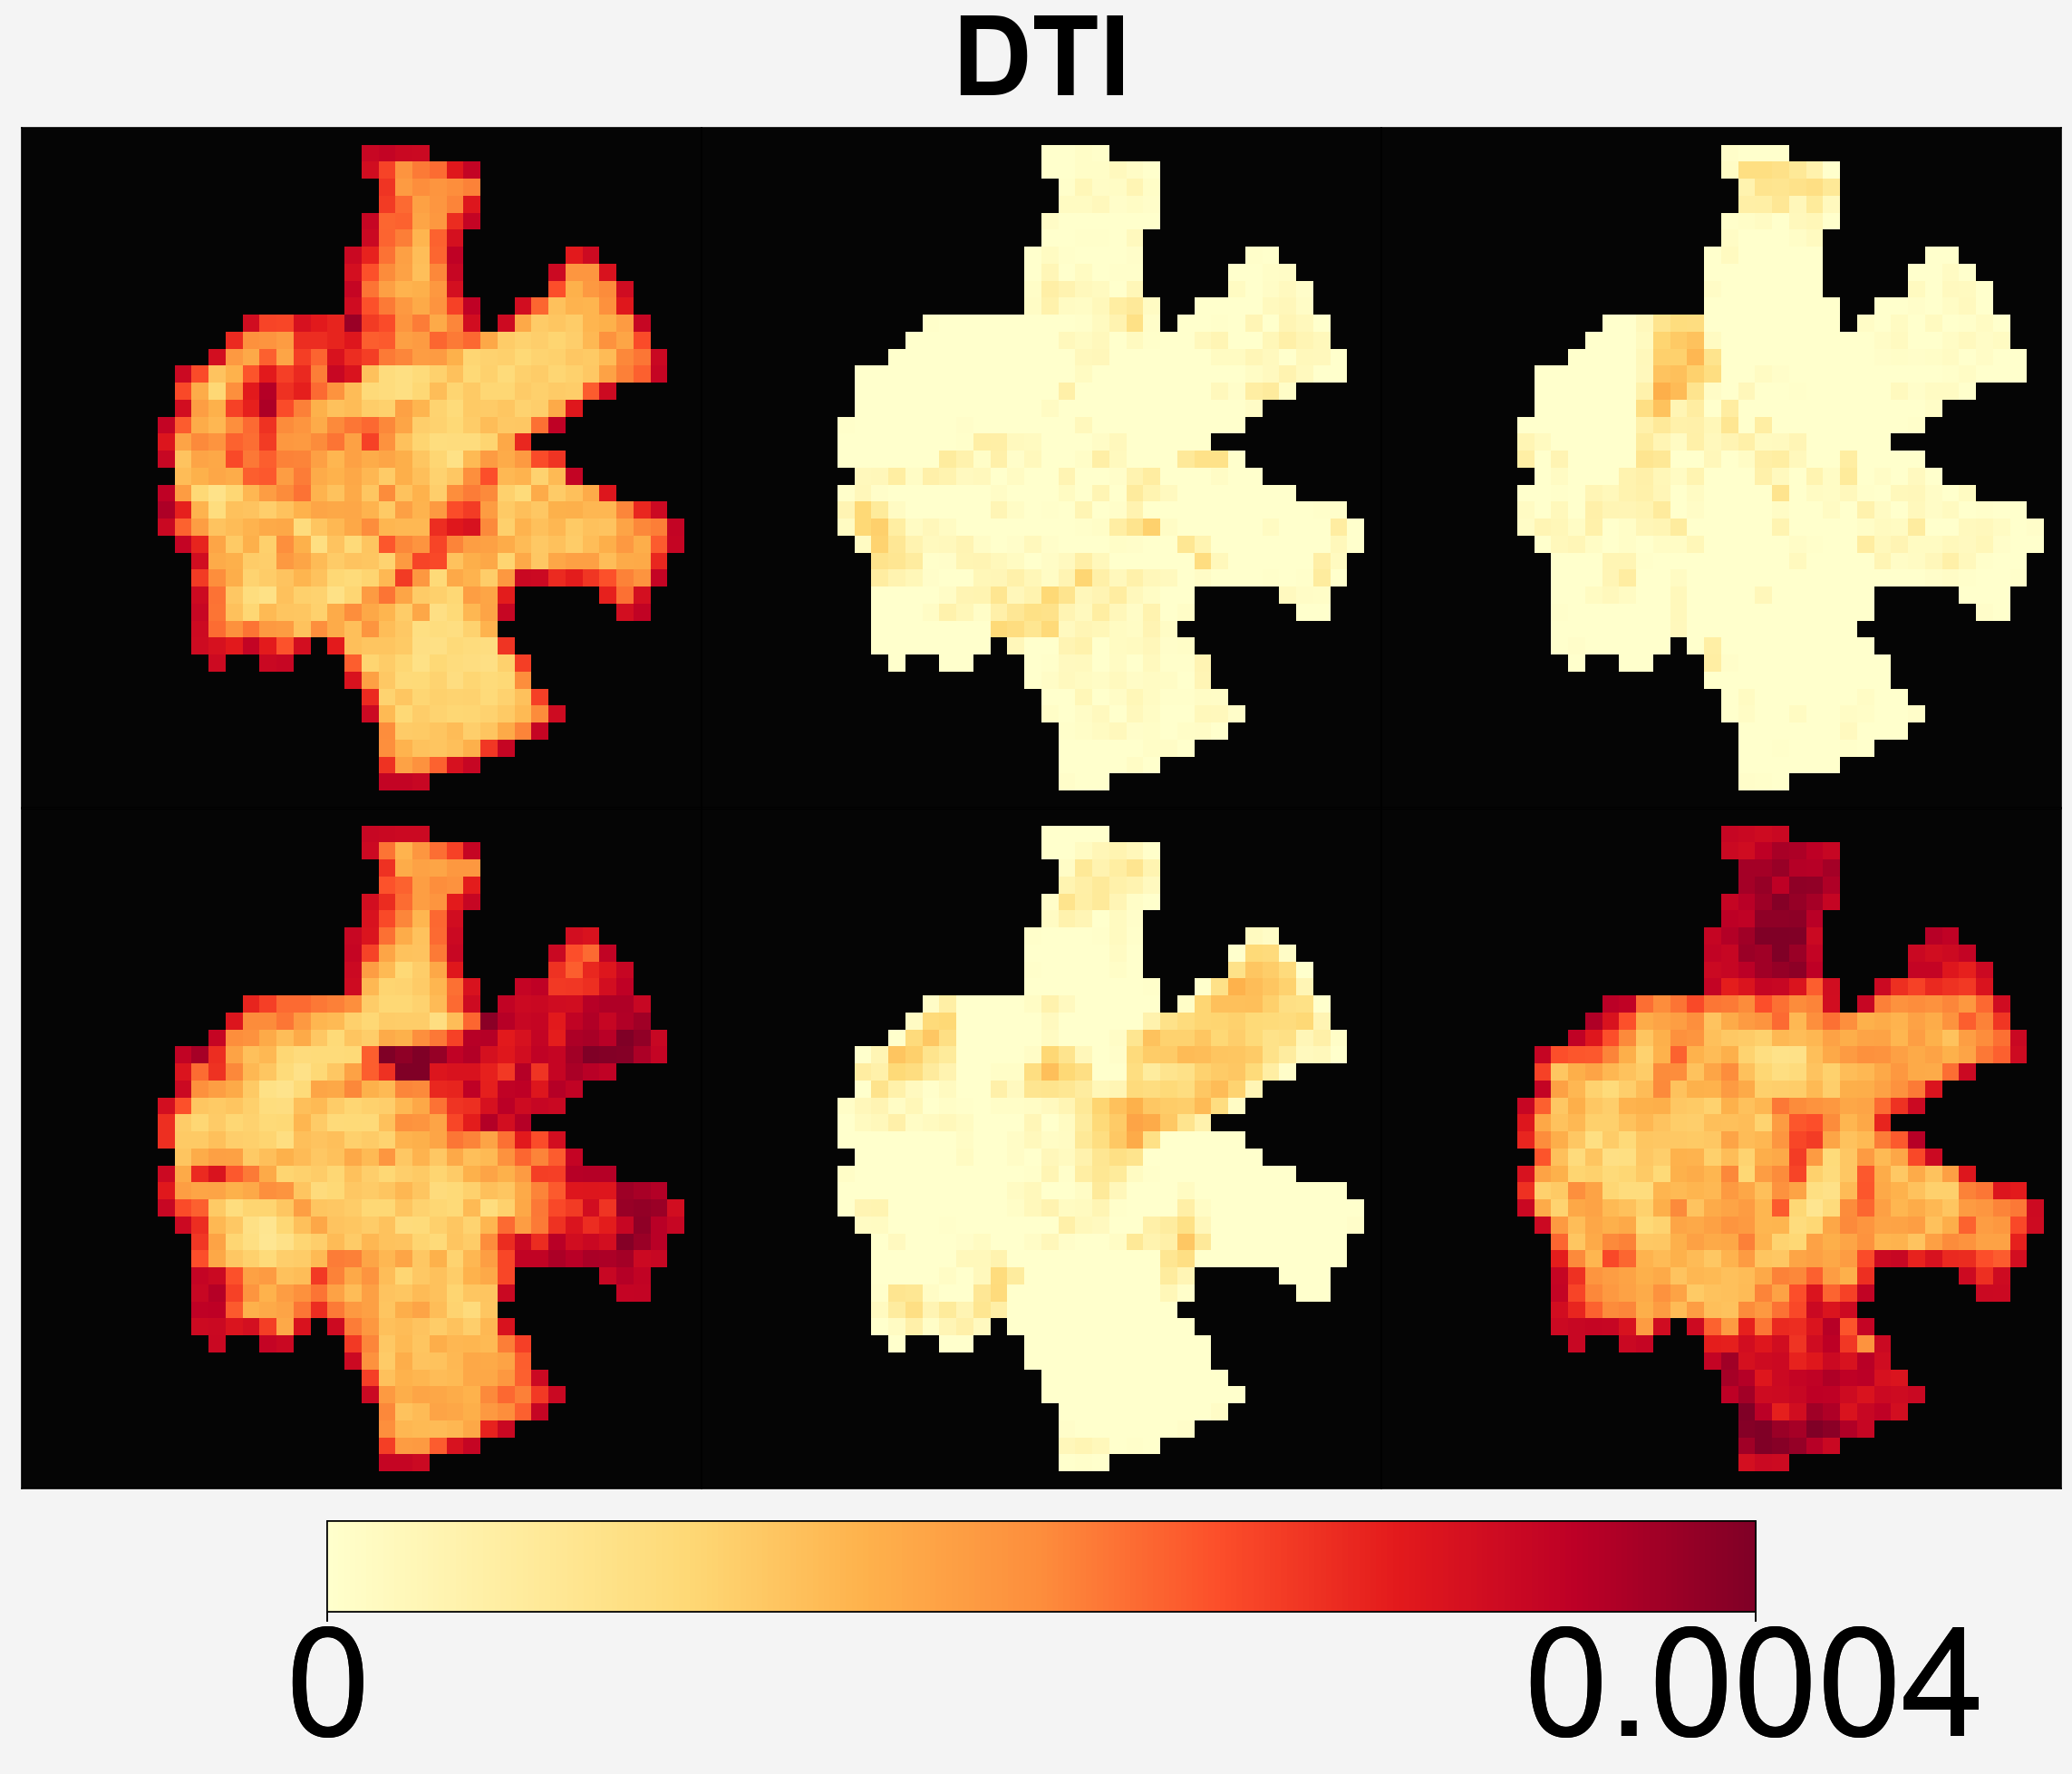

In [22]:
dti_file = np.asarray(nib.load('/Users/zheyu/Downloads/dti_tensor.nii').get_fdata()).astype('float')
template_file_path = '/Users/zheyu/Downloads/phantom_DWI/DiSCo2/high_resolution_40x40x40/DiSCo1_ROIs.nii.gz'
template_file = np.asarray(nib.load(template_file_path).get_fdata()).astype('float')
label_img = np.zeros_like(template_file)
label_img[template_file!=0] = 1
axial, cor, sag = compute_com(label_img)
dti_file[dti_file==0] = np.nan
face_color = '#050505'    
cmap = 'YlOrRd'

fname = '/Users/zheyu/Downloads/Phantom_dti_img.pdf'
with PdfPages(fname) as pdf:
    fig = pplt.figure(share=False, refwidth='30em', suptitle='DTI', fontsize=40)
    axs = fig.subplots(nrows=2, ncols=3, wspace=0.01, hspace=0.01)

    ax1= axs[0, 0]
    ax2= axs[0, 1]
    ax3= axs[0, 2]
    ax4= axs[1, 0]
    ax5= axs[1, 1]
    ax6= axs[1, 2]
    
    face_color = '#050505'
    max_val = 0.0004
    
    ax1.set_facecolor(face_color)
    m = ax1.imshow(np.rot90(dti_file[axial, :, :, 0], 1), cmap=cmap, aspect="equal", vmin = 0, vmax=max_val) 
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax2.set_facecolor(face_color)
    m = ax2.imshow(np.rot90(dti_file[axial, :, :, 1], 1), cmap=cmap, aspect="equal", vmin = 0, vmax=max_val) 
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    ax3.set_facecolor(face_color)
    m = ax3.imshow(np.rot90(dti_file[axial, :, :, 2], 1), cmap=cmap, aspect="equal", vmin = 0, vmax=max_val) 
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    ax4.set_facecolor(face_color)
    m = ax4.imshow(np.rot90(dti_file[axial, :, :, 3], 1), cmap=cmap, aspect="equal", vmin = 0, vmax=max_val) 
    ax4.get_xaxis().set_visible(False)
    ax4.get_yaxis().set_visible(False)
    ax5.set_facecolor(face_color)
    m = ax5.imshow(np.rot90(dti_file[axial, :, :, 4], 1), cmap=cmap, aspect="equal", vmin = 0, vmax=max_val) 
    ax5.get_xaxis().set_visible(False)
    ax5.get_yaxis().set_visible(False)
    ax6.set_facecolor(face_color)
    m = ax6.imshow(np.rot90(dti_file[axial, :, :, 5], 1), cmap=cmap, aspect="equal", vmin = 0, vmax=max_val) 
    ax6.get_xaxis().set_visible(False)
    ax6.get_yaxis().set_visible(False)
    
    cbar = fig.colorbar(m, ticks=[0, max_val], shrink=1, loc='b', length=0.7, width=0.5)
    cbar.ax.tick_params(labelsize=60)
    pdf.savefig(dpi=256)
    pplt.show()
    pplt.close()


/var/folders/_1/84dk44951w16_wfcqz9h1dpw0000gn/T/ipykernel_1373/374456818.py:68: ProplotWarning: Got conflicting or duplicate keyword args: {'length': 0.8, 'shrink': 1}. Using the first one.
  cbar = fig.colorbar(m, ticks=[0, maxval], shrink=1, ax=axs[1, 2], length=0.8, width=0.3)


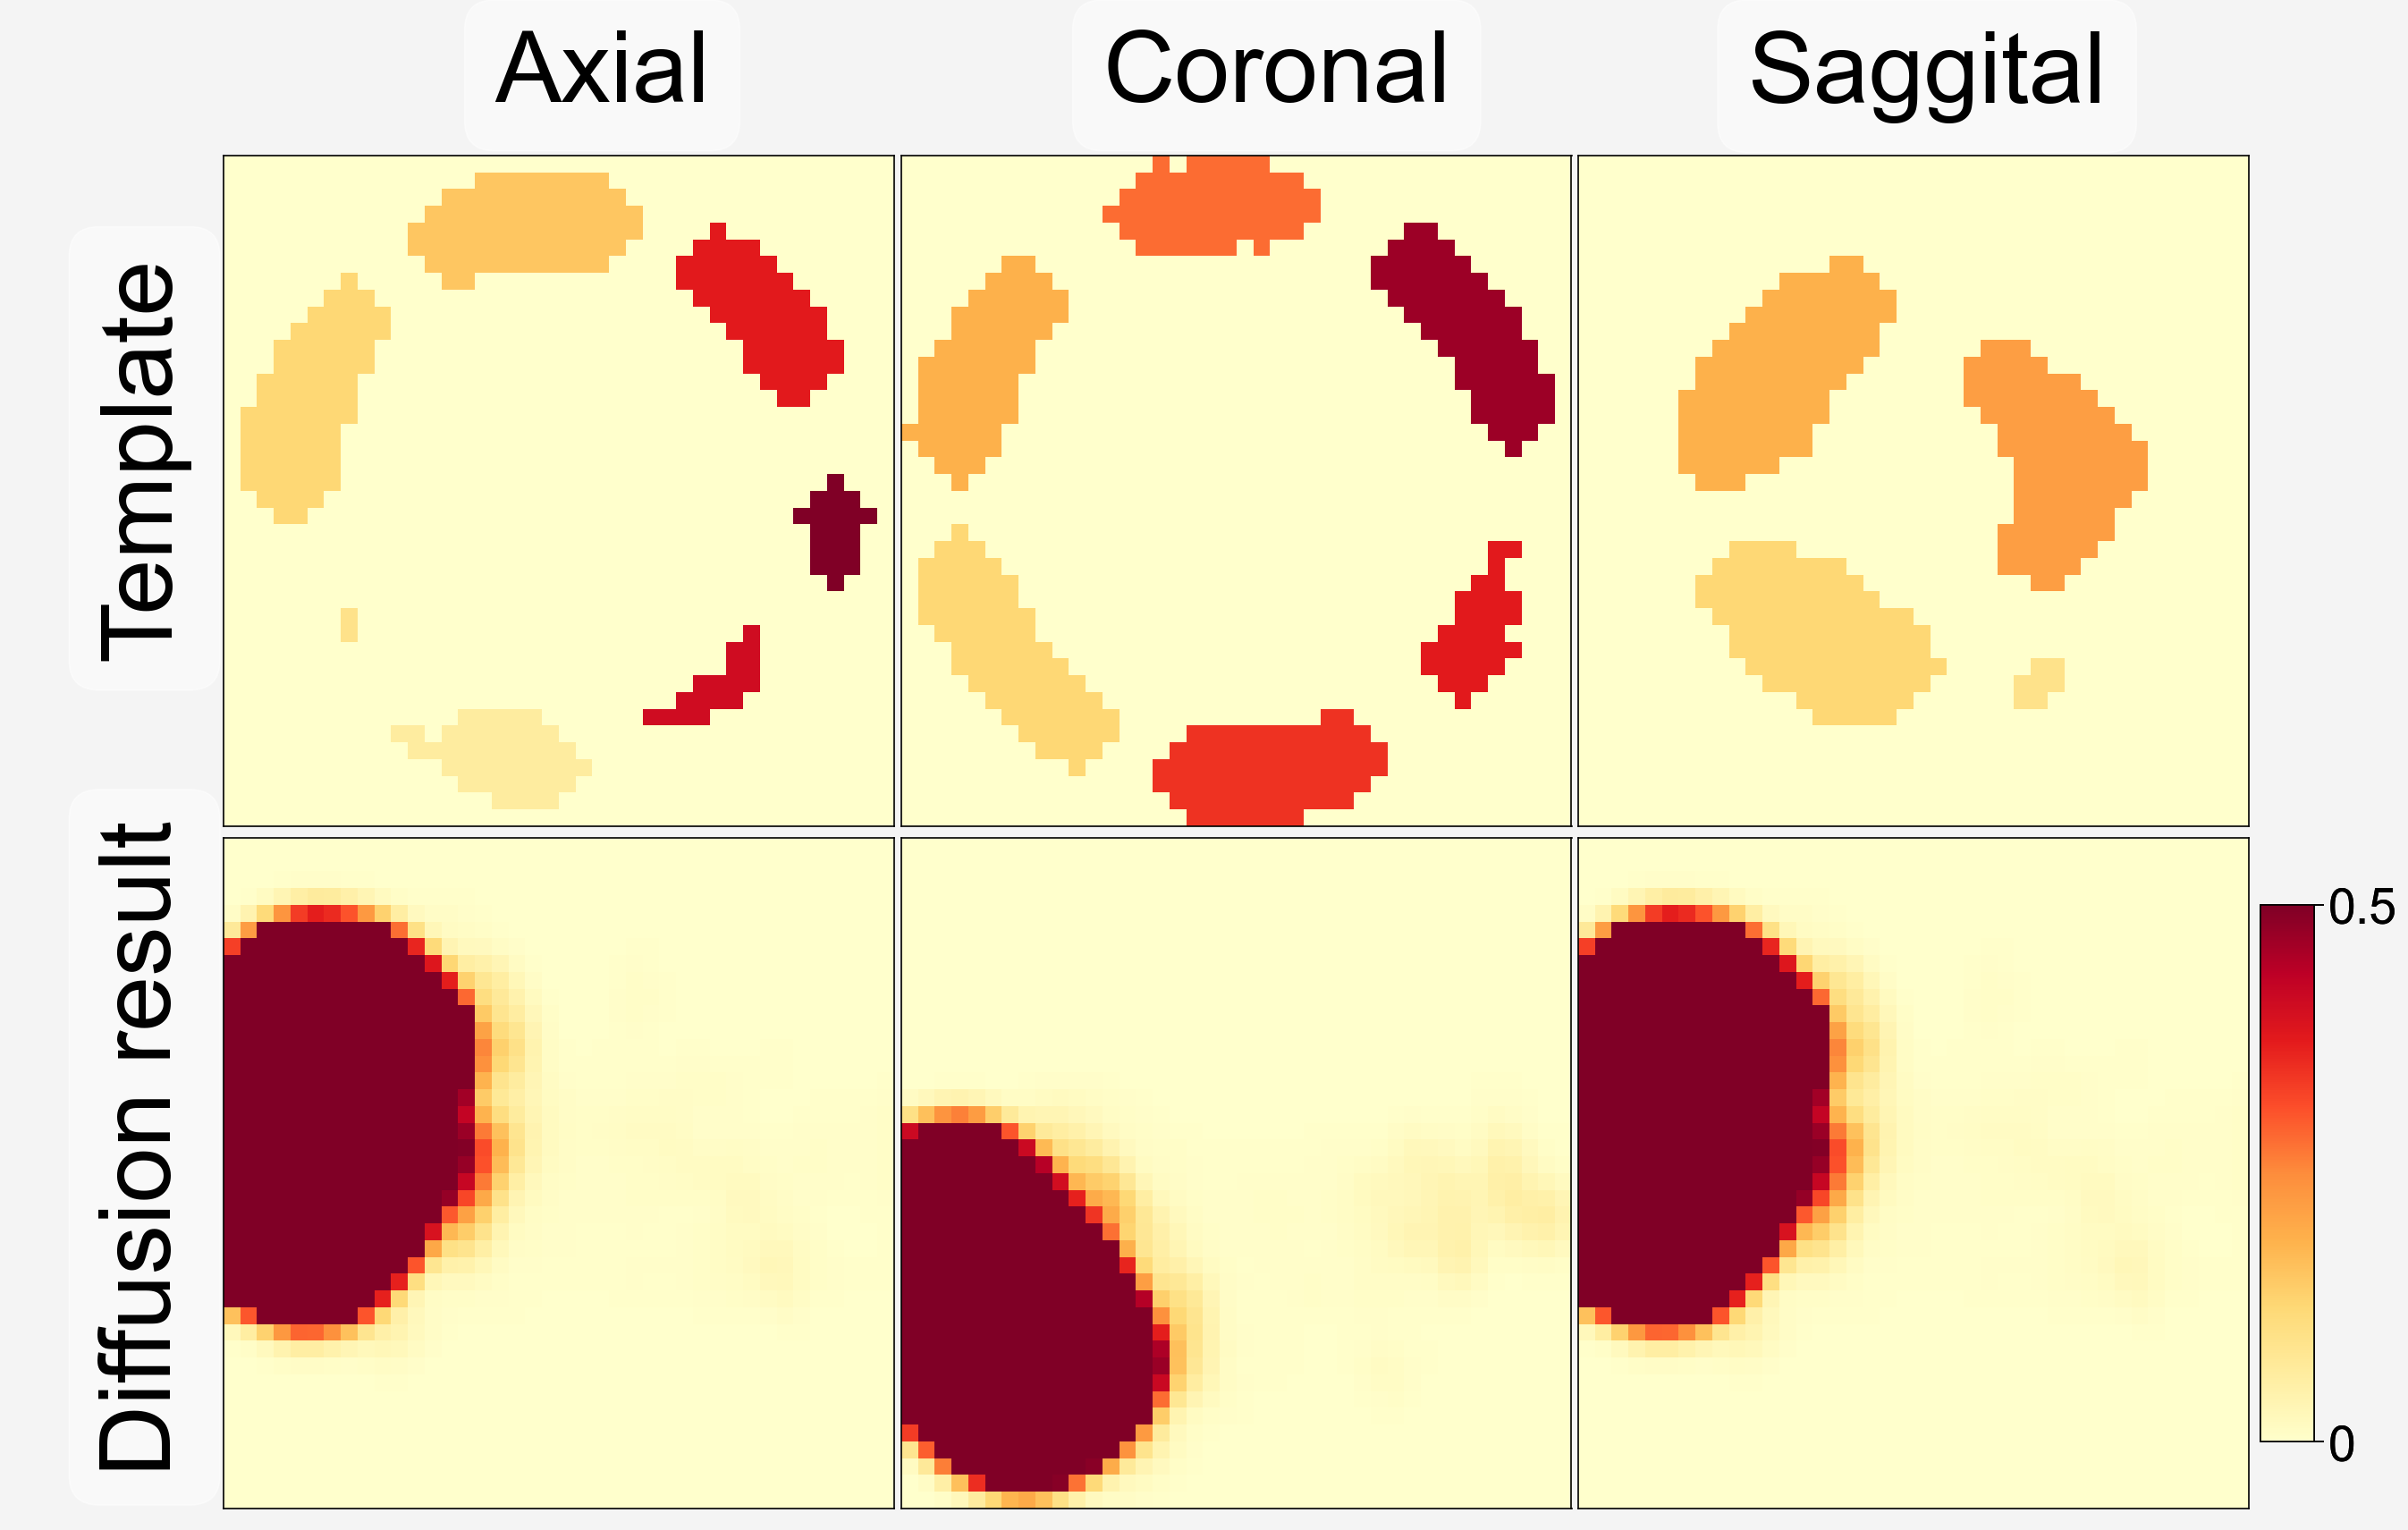

In [57]:
diff_result = np.asarray(nib.load('/Users/zheyu/Downloads/c1_tid_4.nii.gz').get_fdata()).astype('float')
template_file_path = '/Users/zheyu/Downloads/phantom_DWI/DiSCo1/high_resolution_40x40x40/DiSCo1_ROIs.nii.gz'
template_file = np.asarray(nib.load(template_file_path).get_fdata()).astype('float')
label_img = np.zeros_like(template_file)
label_img[template_file==4] = 1
axial, cor, sag = compute_com(label_img)
center_idces = [axial, cor, sag]
diff_result[diff_result==0] = np.nan
face_color = '#050505'    
cmap = 'YlOrRd'
xlabels = ['Axial', 'Coronal', 'Saggital']
ylabels = ['Template', 'Diffusion result']

maxval = 0.5
ext_x = []
fname = '/Users/zheyu/Downloads/Phantom_diffusion_result.pdf'
with PdfPages(fname) as pdf:
    fig = pplt.figure(share=False, refwidth='30em', fontsize=20)
    axs = fig.subplots(nrows=2, ncols=3, wspace=0.3, hspace=0.5, top=7, left=10)
    axs[0, 0].set_facecolor(face_color)
    axs[0, 0].imshow(template_file[axial, :, :], cmap=cmap, aspect="equal", vmin = 0, vmax=16) 
    axs[0, 0].get_xaxis().set_visible(False)
    axs[0, 0].get_yaxis().set_visible(False)
    
    axs[0, 1].set_facecolor(face_color)
    axs[0, 1].imshow(template_file[:, cor, :], cmap=cmap, aspect="equal", vmin = 0, vmax=16) 
    axs[0, 1].get_xaxis().set_visible(False)
    axs[0, 1].get_yaxis().set_visible(False)
    
    axs[0, 2].set_facecolor(face_color)
    axs[0, 2].imshow(template_file[:, :, sag], cmap=cmap, aspect="equal", vmin = 0, vmax=16) 
    axs[0, 2].get_xaxis().set_visible(False)
    axs[0, 2].get_yaxis().set_visible(False)
    
    ext_x.append([axs[0, 0].get_window_extent().x0, axs[0, 0].get_window_extent().width])
    ext_x.append([axs[0, 1].get_window_extent().x0, axs[0, 1].get_window_extent().width])
    ext_x.append([axs[0, 2].get_window_extent().x0, axs[0, 2].get_window_extent().width])
    
    
    axs[1, 0].set_facecolor(face_color)
    axs[1, 0].imshow(diff_result[axial, :, :], cmap=cmap, aspect="equal", vmin = 0, vmax=maxval) 
    axs[1, 0].get_xaxis().set_visible(False)
    axs[1, 0].get_yaxis().set_visible(False)
    
    axs[1, 1].set_facecolor(face_color)
    axs[1, 1].imshow(diff_result[:, cor, :], cmap=cmap, aspect="equal", vmin = 0, vmax=maxval) 
    axs[1, 1].get_xaxis().set_visible(False)
    axs[1, 1].get_yaxis().set_visible(False)
    
    axs[1, 2].set_facecolor(face_color)
    m = axs[1, 2].imshow(diff_result[axial, :, :], cmap=cmap, aspect="equal", vmin = 0, vmax=maxval) 
    axs[1, 2].get_xaxis().set_visible(False)
    axs[1, 2].get_yaxis().set_visible(False)
    
#     inv = fig.transFigure.inverted()
    position = [0.25, 0.53, 0.8]
    for j in range(3):
#         width_left = ext_x[j][0]+ext_x[0][1]/2.
#         some_center = inv.transform((width_left, 1))
        t = plt.figtext(position[j], 0.98, xlabels[j], va="top", ha="center", size=40)
        t.set_bbox(dict(facecolor='#FFFFFF', boxstyle='round', alpha=0.5, edgecolor='#FFFFFF'))
        
    position = [0.7, 0.25]
    for j in range(2): 
        t = plt.figtext(0.06, position[j], ylabels[j], rotation=90, va="center", ha="center", size=40)
        t.set_bbox(dict(facecolor='#FFFFFF', boxstyle='round', alpha=0.5, edgecolor='#FFFFFF'))
    
    cbar = fig.colorbar(m, ticks=[0, maxval], shrink=1, ax=axs[1, 2], length=0.8, width=0.3)
    cbar.ax.tick_params(labelsize=20)
    pdf.savefig(dpi=256)
    pplt.show()
    pplt.close()